In [10]:
# BLUERT demo
from bleurt import score

references = ["This is a test."]
candidates = ["This isn't a test."]

bleurt_scorer = score.BleurtScorer('../BLEURT-20')
scores = bleurt_scorer.score(references=references, candidates=candidates)
assert isinstance(scores, list) and len(scores) == 1
print(scores)

INFO:tensorflow:Reading checkpoint ../BLEURT-20.


INFO:tensorflow:Reading checkpoint ../BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: ../BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: ../BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


[0.6768419742584229]


In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu

file_path = 'final_generated_responses_corrected.csv'
data = pd.read_csv(file_path)
# Define Jaccard similarity function
def jaccard_similarity(doc1, doc2):
    words_doc1 = set(doc1.split()) 
    words_doc2 = set(doc2.split())
    intersection = words_doc1.intersection(words_doc2)
    union = words_doc1.union(words_doc2)
    return float(len(intersection)) / len(union)

# Define custom ROUGE-L function
def calculate_rouge_l(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    reference_len = len(reference_tokens)
    candidate_len = len(candidate_tokens)
    
    dp = [[0] * (candidate_len + 1) for _ in range(reference_len + 1)]
    
    for i in range(reference_len + 1):
        for j in range(candidate_len + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif reference_tokens[i-1] == candidate_tokens[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
                
    lcs_len = dp[reference_len][candidate_len]
    precision = lcs_len / candidate_len if candidate_len > 0 else 0
    recall = lcs_len / reference_len if reference_len > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1_score

# Vectorize text for cosine similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data[['generated_response_prompt1', 'generated_response_prompt2', 'physician_comments']].values.flatten())

# Calculate cosine similarities
cosine_similarities = cosine_similarity(tfidf_matrix)
similarity_results = pd.DataFrame(data['id'], columns=['id'])

# Calculating all similarities
similarity_functions = [cosine_similarity, jaccard_similarity, sentence_bleu, calculate_rouge_l, bleurt_scorer.score]
labels = ['Cosine', 'Jaccard', 'BLEU', 'ROUGE_L', 'BLEURT']

# Calculate all pairwise comparisons
for func, label in zip(similarity_functions, labels):
    pairs = [('generated_response_prompt1', 'generated_response_prompt2'),
             ('generated_response_prompt1', 'physician_comments'),
             ('generated_response_prompt2', 'physician_comments')]
    
    for pair in pairs:
        col_name = f'{label}_Sim_{pair[0][-1]}_{pair[1][-1]}'
        if func == cosine_similarity:
            similarity_results[col_name] = [
                func(tfidf_vectorizer.transform([row[pair[0]]]), 
                     tfidf_vectorizer.transform([row[pair[1]]]))[0, 0]
                for index, row in data.iterrows()
            ]
        elif label == 'BLEURT':  # BLEURT scoring requires a slightly different approach
            similarity_results[col_name] = [
                func(references=[row[pair[0]]], candidates=[row[pair[1]]])[0]
                for index, row in data.iterrows()
            ]
        else:
            similarity_results[col_name] = [
                func(row[pair[0]], row[pair[1]])
                for index, row in data.iterrows()
            ]

similarity_results.head()

/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/dhirpalshah/miniconda3/envs/condavenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

,id,Cosine_Sim_1_2,Cosine_Sim_1_s,Cosine_Sim_2_s,Jaccard_Sim_1_2,Jaccard_Sim_1_s,Jaccard_Sim_2_s,BLEU_Sim_1_2,BLEU_Sim_1_s,BLEU_Sim_2_s,ROUGE_L_Sim_1_2,ROUGE_L_Sim_1_s,ROUGE_L_Sim_2_s,BLEURT_Sim_1_2,BLEURT_Sim_1_s,BLEURT_Sim_2_s
0,1i7s0u,0.632732,0.167837,0.176242,0.233983,0.086379,0.116719,6.797190e-232,8.368341e-232,8.368341e-232,0.214976,0.088028,0.094737,0.503554,0.409111,0.453351
1,1i7qst,0.689079,0.258419,0.439947,0.260652,0.115942,0.135048,6.420645e-232,8.859356e-232,8.859356e-232,0.272637,0.096718,0.092025,0.491011,0.451046,0.497550
2,1i7hzo,0.481272,0.301546,0.243571,0.210784,0.081911,0.104730,6.561680e-232,9.405151e-232,9.342655e-232,0.143713,0.067797,0.077348,0.471296,0.434182,0.398693
3,1iawxh,0.368036,0.181209,0.223521,0.114441,0.078067,0.103321,6.848004e-232,8.256980e-232,8.456086e-232,0.129801,0.074074,0.117137,0.429575,0.450070,0.422977
4,1i9v7i,0.387593,0.203380,0.231738,0.177945,0.093093,0.147059,6.950441e-232,8.532517e-232,8.414799e-232,0.141317,0.080257,0.113924,0.472769,0.447642,0.418911


In [12]:
similarity_results.to_csv("final_analysis.csv", index=False)

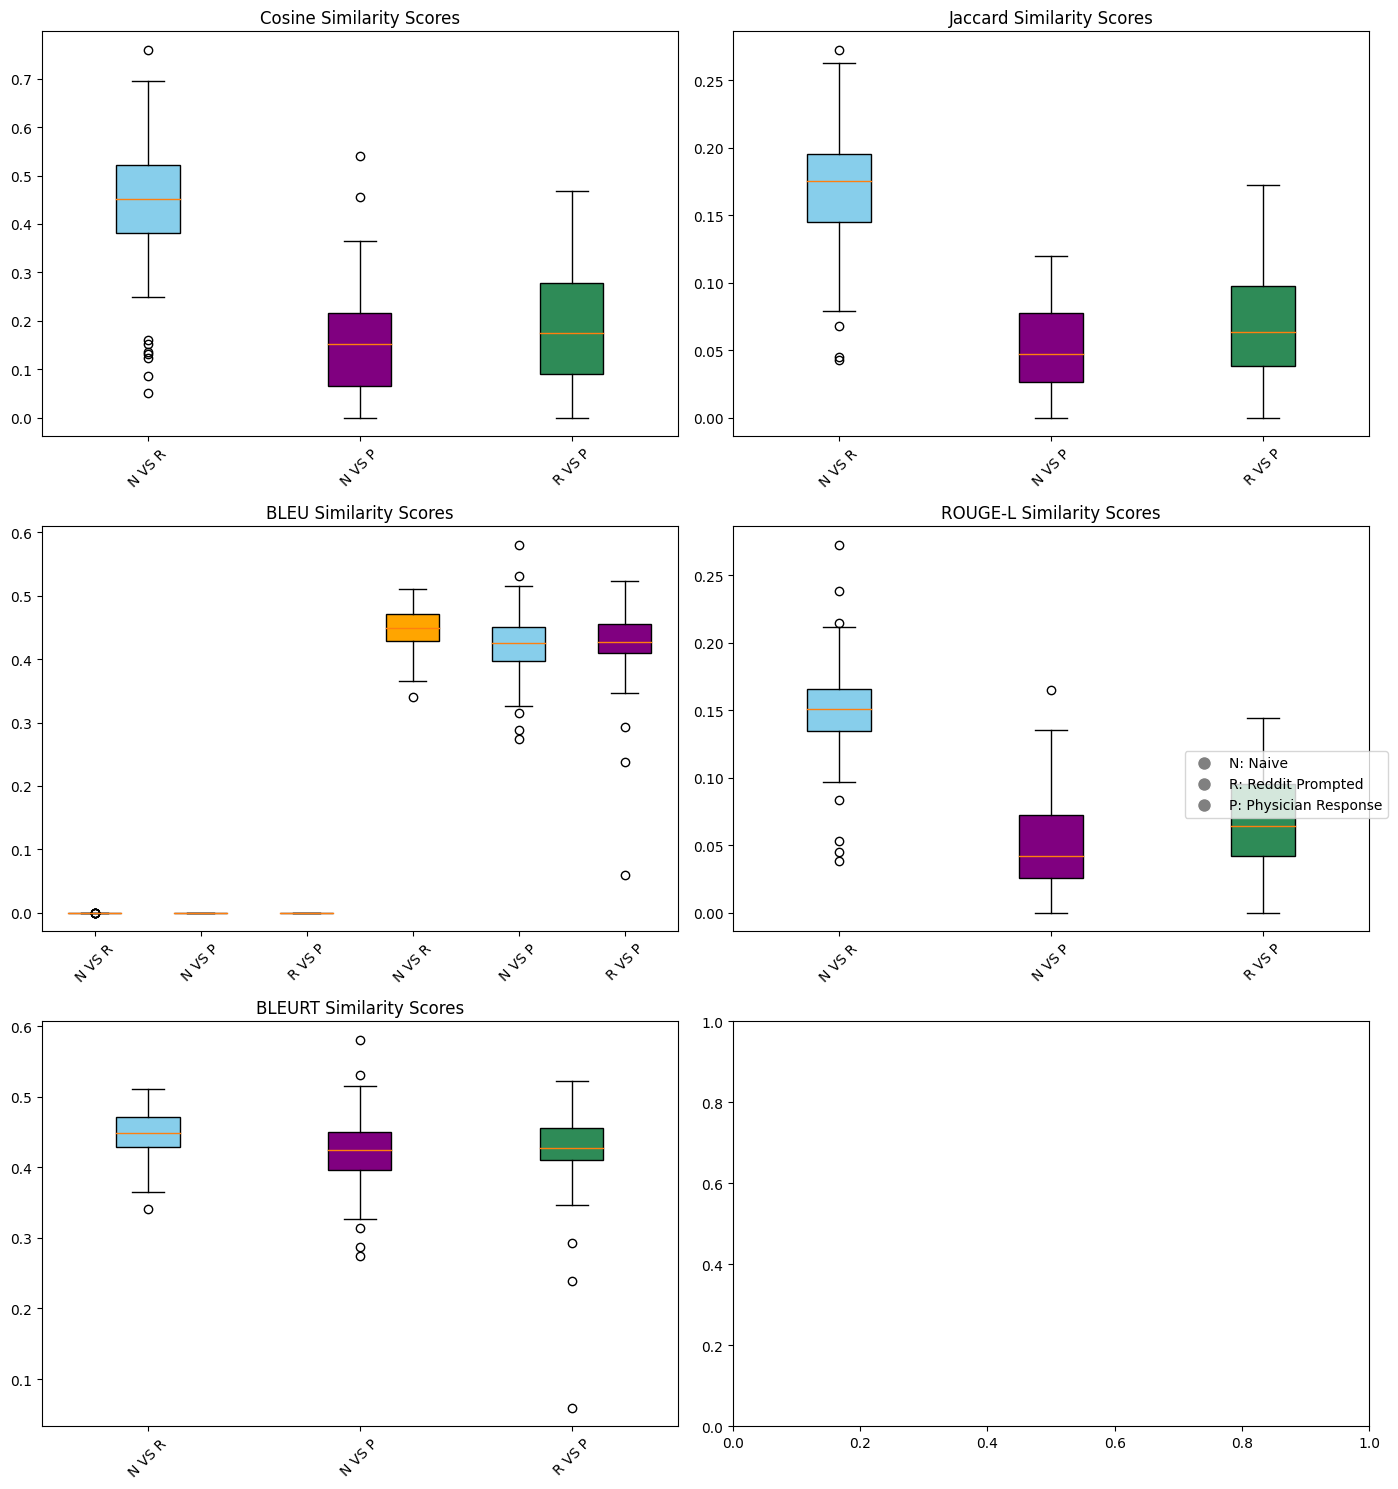

In [13]:
import matplotlib.pyplot as plt

final_analysis_path = 'final_analysis.csv'
final_analysis_data = pd.read_csv(final_analysis_path)
final_analysis_data.head()

colors = ['skyblue', 'purple', 'seagreen', 'orange']  # Added one more color for BLEURT

def apply_box_color(bp, colors):
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# Adjusting subplot layout to accommodate an additional row for BLEURT
fig, axs = plt.subplots(3, 2, figsize=(14, 15), sharey=False)

# Filter columns for each similarity type
cosine_cols = [col for col in final_analysis_data.columns if 'Cosine' in col]
jaccard_cols = [col for col in final_analysis_data.columns if 'Jaccard' in col]
bleu_cols = [col for col in final_analysis_data.columns if 'BLEU' in col]
rouge_cols = [col for col in final_analysis_data.columns if 'ROUGE_L' in col]
bleurt_cols = [col for col in final_analysis_data.columns if 'BLEURT' in col]  # New BLEURT columns

rename_labels = {
    '1': 'N',  # Naive
    '2': 'R',  # Reddit-Prompted
    's': 'P'   # Physician Response
}

def rename_axis_labels(labels):
    new_labels = []
    for label in labels:
        parts = label.split('_')
        new_label = f'{rename_labels[parts[-2][0]]} VS {rename_labels[parts[-1][0]]}'
        new_labels.append(new_label)
    return new_labels

# Plot each similarity type with updated labels and colors
for i, (cols, title) in enumerate(zip([cosine_cols, jaccard_cols, bleu_cols, rouge_cols, bleurt_cols],
                                      ['Cosine Similarity Scores', 'Jaccard Similarity Scores',
                                       'BLEU Similarity Scores', 'ROUGE-L Similarity Scores', 'BLEURT Similarity Scores'])):
    ax = axs[i//2, i%2]
    bp = ax.boxplot(final_analysis_data[cols], patch_artist=True)
    ax.set_title(title)
    ax.set_xticklabels(rename_axis_labels(cols), rotation=45)
    apply_box_color(bp, colors * (len(cols)//3))

# Adjust subplot for legend placement
fig.subplots_adjust(right=0.85, top=0.95)
# Create legend explaining each label
labels = ['N: Naive', 'R: Reddit Prompted', 'P: Physician Response']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor='gray', markersize=10) for label in labels]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
